### Instructions
Run all cells until "Running algorithm". Then follow the instructions listed in order to run the algorithm and to get the visualizations.

### Imports

In [ ]:
# !pip install networkx
# !pip install pandas
# !pip install pyhive
# !pip install thrift
# !pip install scipy
# !pip install matplotlib
# !pip install plotly

In [31]:
import sys
import pickle
import pandas as pd
import ipywidgets as widgets
import datetime
import networkx as nx

MODULES_PATH = "../modules"
if MODULES_PATH not in sys.path:
    sys.path.append(MODULES_PATH)

In [32]:
from hive_wrapper import *
from database import *
from utils import *
from route_planner import *
from visualization import * 

%reload_ext autoreload
%autoreload 2

In [40]:
# username = "elmalki"
# _, host, port = get_env_vars()
# hive_connection = HiveConnection(username, host, port)
# db = Database(hive_connection)

db = None # access to the database with delays is not available for demo

### Load the Network and Necessary Data

In [22]:
!git lfs pull

In [23]:
with open("../data/transport_network.pkl", "rb") as f:
    graph = pickle.load(f)

In [24]:
with open("../data/stops.pkl", "rb") as f:
    stops_df = pickle.load(f)

In [25]:
# build graph to find railway path
railway_route = pd.read_csv("../data/linie-mit-polygon.csv", encoding='latin1')
graph_coordinate = build_coordinate_graph(railway_route)

#### Functions for interface
Those functions need to stay in this notebook in order for the widgets to work.

In [33]:
# Needs to be in this notebook for widgets interaction
start_search = widgets.Button( 
    description='Start search', 
    disabled=False, 
    button_style='info', # 'success', 'info', 'warning', 'danger' or '' 
    tooltip='Run button function', 
    icon='play' 
    ) 

def on_run_button_clicked(b): 
    with output_box: 
        print('running...') 
        global travel_success
        global n_trips
        travel_success, travel_time, id_arrival, id_departure, n_trips = get_input_value(input_success, input_time, input_arrival, input_departure, stops_df, number_input)
        deadline = datetime.datetime.strptime(input_time.value.strftime('%H:%M:%S'), '%H:%M:%S')
        rp = RoutePlanner(graph, id_departure, id_arrival, deadline=deadline, database=db)
        global route 
        route = rp.find_paths(n_trips)
        print('Done with computing')
def get_input_value(input_success, input_time, input_arrival, input_departure, stops_df, number_input):
    ''' Get all input values'''
    # Get departure_id: If parent station available, take parent. Otherwise take last 
    if input_arrival.value =='' or input_departure == '':
        print('\n Error: Input is not complete. Please fill in your travel information')
        sys.exit()
    sub_dep = stops_df[stops_df.stop_name == input_departure.value]
    if len(sub_dep) ==1:
        id_departure = sub_dep.stop_id.iloc[0]
    elif sub_dep.parent_station.iloc[0] != '':
        id_departure =sub_dep.parent_station.iloc[0]
    else: id_departure = sub_dep.stop_id.iloc[-1]

    # Same for arrival_id
    sub_dep = stops_df[stops_df.stop_name == input_arrival.value]
    if len(sub_dep) ==1:
        id_arrival = sub_dep.stop_id.iloc[0]
    elif sub_dep.parent_station.iloc[0] != '':
        id_arrival =sub_dep.parent_station.iloc[0]
    else: id_arrival = sub_dep.stop_id.iloc[-1]

    # Get other values from input directly
    travel_success = input_success.value
    travel_time = input_time.value
    n_trips = int(number_input.value)
    return travel_success, travel_time, id_arrival, id_departure, n_trips

### Running algorithm 

**Run the cell below to generate the input widgets.**
- Type the departure stop and arrival stop in to the field and choose one of the valid propositions.
- Choose an arrival time between 6am included and 10pm excluded 
- Choose the probability of success for which the routes should be distinguished 
- Choose number of routes that the algorithm will compute 

**Click on the start search button:** 
- Once the algorithm starts, you will see "running..."
- Once the algorithm is done, you will see "Done with computing"

**Run the remaining cells to get the visualizations.**

In [35]:
interface, input_success, input_arrival, input_departure, input_time, number_input = build_input(stops_df)
start_search
display(interface)
output_box = widgets.Output() 
display(start_search, output_box) 
start_search.on_click(on_run_button_clicked)

Button(button_style='info', description='Start search', icon='play', style=ButtonStyle(), tooltip='Run button …

Output()

If you want to run the algorithm manually without the input interface, you can uncomment the cell below and give the corresponding intput for n_trips (Number of routes to be shown), travel_success (Probability of success), deadline (Arrival time), the start and end stop-id.

In [18]:
# To run manually
'''
n_trips = 5
travel_success = 95
deadline = datetime.datetime.strptime('13:30:00', '%H:%M:%S')

rp = RoutePlanner(graph, "8572644", "8575929", deadline=deadline, database=db)
route = rp.find_paths(n_trips)
'''

'\nn_trips = 5\ntravel_success = 95\ndeadline = datetime.datetime.strptime(\'13:30:00\', \'%H:%M:%S\')\n\nrp = RoutePlanner(graph, "8572644", "8575929", deadline=deadline, database=db)\nroute = rp.find_paths(n_trips)\n'

**Run the cell below to get an overview figure that shows all computed routes. Choose a route you're interested in to get more detailed visualizations in the cells below.**

The routes are sorted according to:
- Latest departure time
- Least walking time
- Least number of transfers

If it meets the probability of success it is shown in dark blue and bold, otherwise in lightblue. 
The distance between each point corresponds to the respective travel time compared to the overall travel time of the route. 
If the edge is a walking edge, it is visualized with a dotted line. In addition, only walking between different stops is visualized e.g., a transfer within Zurich HB would not be visualized. 

Dropdown(description='Get details about route:', layout=Layout(width='25%'), options=(1, 2, 3), style=Descript…

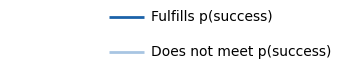

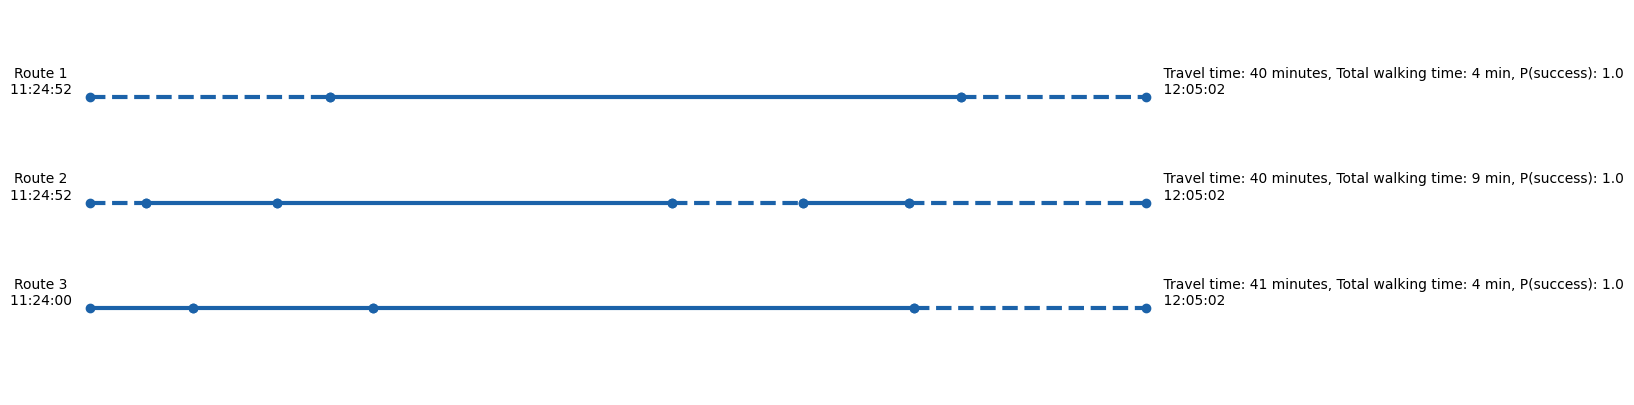

In [36]:
choose_trip = get_choosetrip_w(route)
figure, stops_tot, transport_type , arrival_tot, departure_tot, x_tot, keep_index_tot, type_edge_tot, route_name_tot, headsign_tot, stops_id_tot, trip_id_tot= timetable_overview(route, travel_success, n_trips)
choose_trip

**Run the cell below to get a visualization of a specific route.** 


This visualization shows all the stop names of the route and the corresponding departure/ arrival time. Stops within the same trip are connected and have the same color. Walks between different stops is visualized by black dotted lines.  

If the of the transportation vehicle is available it will be listed on the left side of the graph. Similarly with the headline (Direction specification) of the transport vehicle. 

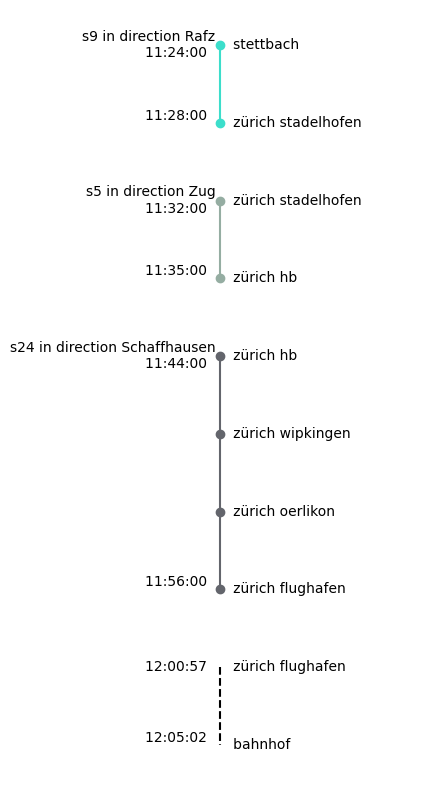

In [41]:
y_label, color_segment, departure_seg, arrival_seg, travel_name, line_style, figure  = detailed_viz1(choose_trip, stops_tot, route_name_tot, headsign_tot, trip_id_tot, keep_index_tot, type_edge_tot, departure_tot, arrival_tot)

**Run the cell below to get a visualization of a map of a specific route.** 

The map shows the specified route, where each line segment has the corresponding color to the visualization above. 
Trains are indicated with a dot label, other transport types (bus and tram) are indicated with a line label.

The coordinates of train lines stem from the SBB railway-data (https://data.sbb.ch/explore/dataset/linie-mit-polygon/information/?flg=de). We assumed that the train runs through the shortest path between each intermediate stop. Therefore the train-route-coordinates were found by building a network with coordinate data and with dijkstra. In some rare cases the SBB railway-data misses some stops. For those we connected the stops with a straight line. 

Stops that are not train stops are connected by a straight line. 

All stops are visualized by a black dot and have a hover effect- showing the corresponding stop name.

In [42]:
figure2 = detailed_viz2(choose_trip, y_label, color_segment, arrival_seg, arrival_seg, travel_name, stops_id_tot, stops_df, railway_route, stops_tot, graph_coordinate, line_style)